In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

import torch
import torch.nn.functional as F
from torchvision import models, transforms

from lime_ieinn import ImageExplainer
from skimage.segmentation import mark_boundaries

C:\Users\kenta\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


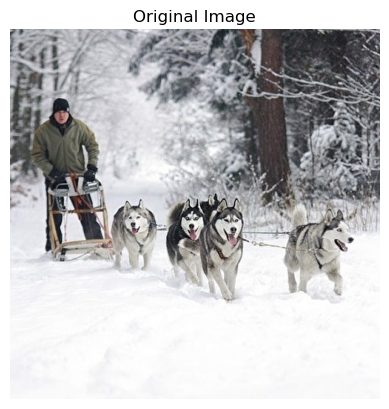

In [9]:
image = Image.open("./data/dogsled.png").convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [10]:
model = models.inception_v3(pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

C:\Users\kenta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kenta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(LABELS_URL).text.strip().split("\n")

In [12]:
def predict_fn(images_np):
    images = torch.from_numpy(images_np).permute(0, 3, 1, 2).float() / 255.0
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    images = torch.stack([normalize(img) for img in images])
    with torch.no_grad():
        outputs = model(images)
    return outputs.softmax(dim=1).cpu().numpy()

In [13]:
explainer = ImageExplainer(kernel_width=0.25, additivity_order=2, epochs=100)

explanation = explainer.explain_instance(
    np.array(image),
    predict_fn,
    num_samples=100,
    num_features=100,
    grid_size=4
)

# 最も予測スコアが高いクラスを取得
probs = predict_fn(np.expand_dims(np.array(image), axis=0))
top_label = int(np.argmax(probs))
top_class = imagenet_classes[top_label]

print(f"LIMEで説明するラベル: {top_label} - {top_class}")

Epoch [1/100], loss: 76.17071164 val_loss: 7.63352752
EarlyStopping counter: 1 out of 20
Epoch [2/100], loss: 31.92578602 val_loss: 8.65719438
Epoch [3/100], loss: 19.90709543 val_loss: 4.53994364
Epoch [4/100], loss: 31.24307823 val_loss: 3.79468024
Epoch [5/100], loss: 19.59920311 val_loss: 1.76104277
EarlyStopping counter: 1 out of 20
Epoch [6/100], loss: 16.57005882 val_loss: 2.20908597
EarlyStopping counter: 2 out of 20
Epoch [7/100], loss: 13.29112554 val_loss: 4.26419914
Epoch [8/100], loss: 21.44131982 val_loss: 1.71337739
Epoch [9/100], loss: 16.05975676 val_loss: 1.22493610
EarlyStopping counter: 1 out of 20
Epoch [10/100], loss: 6.29829443 val_loss: 2.97735393
EarlyStopping counter: 2 out of 20
Epoch [11/100], loss: 8.44263375 val_loss: 1.40497848
EarlyStopping counter: 3 out of 20
Epoch [12/100], loss: 6.82344019 val_loss: 1.41470045
Epoch [13/100], loss: 3.99725825 val_loss: 0.76022044
Epoch [14/100], loss: 2.34374809 val_loss: 0.72434641
Epoch [15/100], loss: 2.62423265 v

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


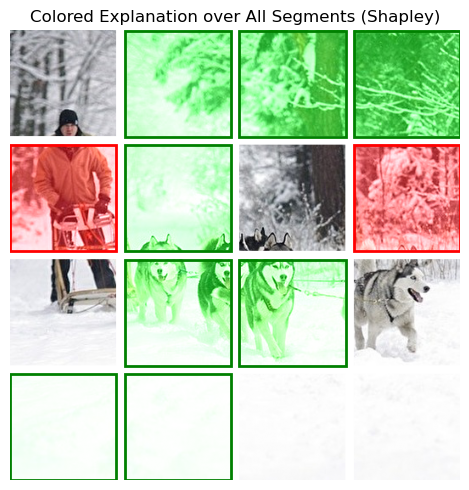

In [7]:
explanation.plot_colored_segment_tiles(top_k=10)

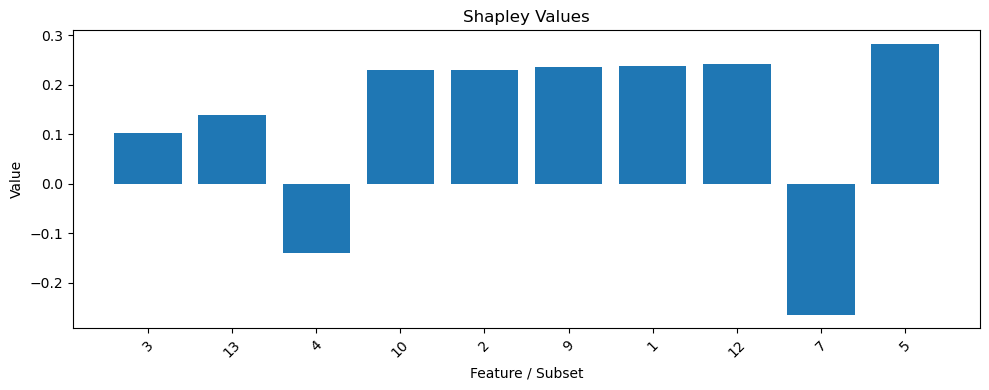

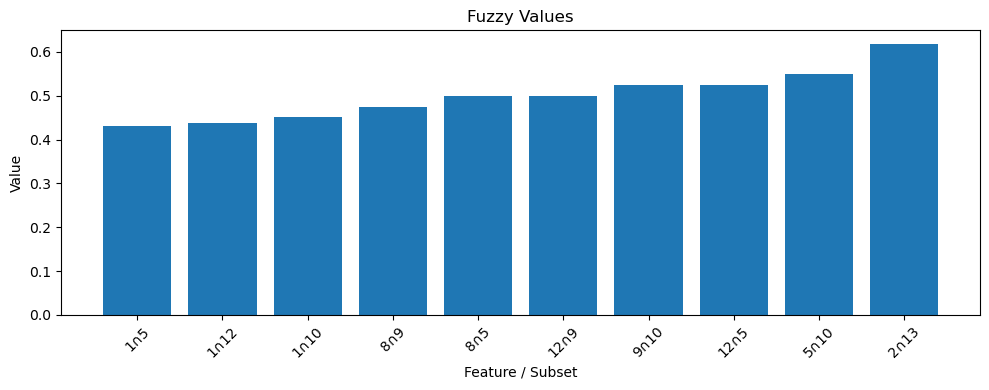

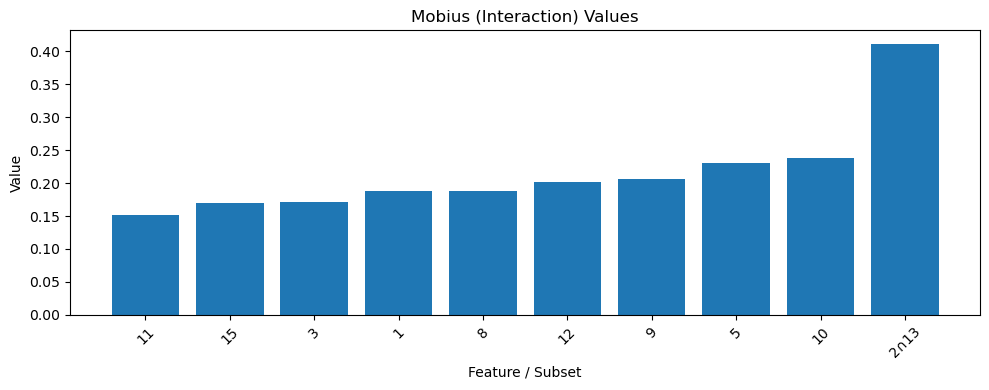

In [8]:
explanation.plot(mode="shapley")
explanation.plot(mode="fuzzy")
explanation.plot(mode="mobius")

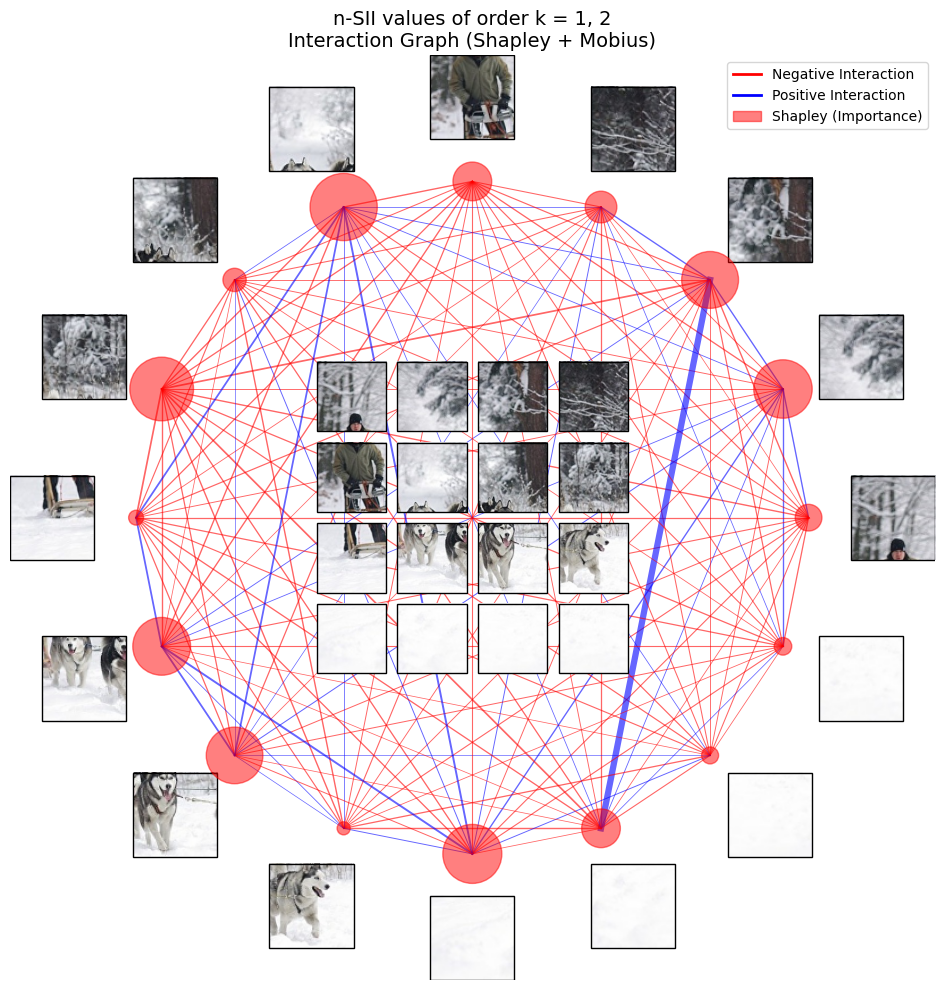

In [9]:
explanation.plot_circular_interaction_graph()